In [105]:
import PIL
import datetime
import os
from os import listdir as ls

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, transform

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import albumentations as A
from albumentations.pytorch import ToTensor

from torch.utils.tensorboard import SummaryWriter

plt.ion()
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [90]:
!kill 398

In [101]:
!ls ../../../datasets/ilyas/ChestNets/

augmentations_images	    __init__.py
aux_materials		    kazan_data
check_folds.ipynb	    kazan_data_score.ipynb
chestnet_info_data	    keras_models
chestNetsMainAugm.ipynb     logs_nnets
chestNetsMain.ipynb	    logs_tboard
convert_dcm.ipynb	    lung_dataset_dcm
data_generator_nopd_map.py  lung_dataset_dcm.zip
data_generator_nopd.py	    my_augmentations.py
data_generator_path.py	    nn_settings
data_generator.py	    plot_curves.ipynb
data_generator_ram.py	    prepare_augm_files.ipynb
draw_CAM.ipynb		    prepare_folds_holdout.ipynb
evaluate_models.ipynb	    prepare_unique_patients_folds_holdout.ipynb
folds			    propotype_thresholds
folds_no_intersec	    __pycache__
images			    README.md
images_bspline		    scores_df
images_bspline2		    set_thresholds.ipynb
images_bspline3		    setup.sh
images_demons1		    test_generator.ipynb
images_demons2		    test_ram_generator.py
images_trans


In [91]:
train_log_dir = os.path.join(".././logs/tensorboard/train/",
                                datetime.datetime.now().strftime("%Y-%m-%d_%H-%m"))
print('nohup tensorboard --logdir='+train_log_dir+' &')
os.makedirs(train_log_dir, exist_ok=True)

nohup tensorboard --logdir=.././logs/tensorboard/train/2019-05-21_15-05 &


In [10]:
train_log_dir = '.././logs/tensorboard/train/2019-05-21_10-05'

In [93]:
train_summary_writer = SummaryWriter(train_log_dir)

In [97]:
def show_example(example):
    """
    Show image with labels
    Args:
    example: dict or image(ndarray)
    """
    plt.figure()
    if isinstance(example, dict):
        image = example['image']
        plt.title(str(example['labels']))
    else:
        image = example
    plt.imshow(image)
    plt.show()  
    

def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['labels']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    print('Batch shape', images_batch.size())

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
    

def show_train_batches(dataloader, i):
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['labels'].size())

        if i_batch == i:
            plt.figure()
            show_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

In [98]:
class ChestnetDataset(Dataset):
    """Chest X-ray picture dataset annotated with patologies"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = cv2.imread(img_name)
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.df.iloc[idx, 1:-1].values.astype(int)
        sample = {'image': image, 'labels': labels}

        if self.transform:
            # Apply tranform to numpy.ndarray which represents sample image
            augmented = self.transform(image=sample['image'])
            sample['image'] = augmented['image']
            sample['labels'] = torch.from_numpy(sample['labels']).float()
        return sample

0 torch.Size([32, 3, 256, 256]) torch.Size([32, 14])
1 torch.Size([32, 3, 256, 256]) torch.Size([32, 14])
2 torch.Size([32, 3, 256, 256]) torch.Size([32, 14])
Batch shape torch.Size([32, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


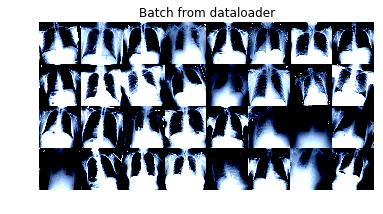

In [104]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(),
    A.Rotate(limit=30),
    A.RandomBrightnessContrast(),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensor()
])
val_transform = A.Compose([ 
    A.Resize(256, 256),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensor()
])


train_dataset = ChestnetDataset('../dataset/fold0123.csv', '../../../datasets/ilyas/ChestNets/images/',
                                           transform=train_transform)
val_dataset = ChestnetDataset('../dataset/fold4.csv', '../../../datasets/ilyas/ChestNets/images/',
                                           transform=val_transform)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=8)



show_train_batches(train_dl, 2)

In [106]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = torchvision.models.densenet121()

state_dict = torch.load('../weights/densenet121_pretrained.pth')
# '.'s are no longer allowed in module names, but pervious _DenseLayer
# has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
# They are also in the checkpoints in model_urls. This pattern is used
# to find such keys.
pattern = re.compile(
    r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
for key in list(state_dict.keys()):
    res = pattern.match(key)
    if res:
        new_key = res.group(1) + res.group(2)
        state_dict[new_key] = state_dict[key]
        del state_dict[key] 
net.load_state_dict(state_dict)


num_ftrs = net.classifier.in_features
net.classifier = nn.Linear(num_ftrs, 14)


net.to(device);

In [107]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [109]:
def train(train_dl, val_dl):
    for epoch in range(60):  # loop over the dataset multiple times

        train_average_loss = 0.0
        val_average_loss = 0.0
        for i, data in enumerate(train_dl, 0):
            # get the inputs
            inputs, labels = data['image'].to(device), data['labels'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_average_loss += loss.item()
        train_average_loss /= len(train_dl)
        with torch.no_grad():
            for i, data in enumerate(val_dl, 0):
                inputs, labels = data['image'].to(device), data['labels'].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_average_loss += loss.item()
        
        val_average_loss /= len(val_dl)
        
        train_summary_writer.add_scalar('train_loss', train_average_loss, global_step = epoch)
        train_summary_writer.add_scalar('val_loss', val_average_loss, global_step = epoch)
        train_summary_writer.close()
        
        torch.save(net.state_dict(), '../weights/densenet1_epoch'+str(epoch)+'.pth')
        print('[%d] train_loss: %.3f; val_loss: %.3f' % (epoch + 1, train_average_loss, val_average_loss))
    
    
    print('Finished Training')

In [ ]:
%%time
train(train_dl, val_dl)